In [29]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm_notebook

from nltk.corpus import stopwords

from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

import pickle
from sklearn.metrics import classification_report

import pandas as pd
import numpy as np
import os

from IPython.display import display
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
import nltk
nltk.downloader.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from tqdm import tqdm
import scipy as sp
import pickle
from sklearn.model_selection import train_test_split
import pysentiment2 as ps 
import pandas as pd
import numpy as np
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow import keras

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/prashanth/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [16]:
MAX_NB_WORDS = 100000    # max no. of words for tokenizer
MAX_SEQUENCE_LENGTH = 2000 # max length of each entry (sentence), including padding
VALIDATION_SPLIT = 0.2   # data for validation (not used in training)
EMBEDDING_DIM = 100      # embedding dimensions for word vectors (word2vec/GloVe)
GLOVE_DIR = "SWM_Data/glove.6B."+str(EMBEDDING_DIM)+"d.txt"

In [17]:
data = pd.read_csv('SWM_Data/Apple_Processed.csv')

In [18]:
data = data[data.text.notnull()]

In [19]:
y = data['label'].values

In [20]:
x = data['text']
x = list(x)

In [36]:
# X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [38]:
# y_train

array([0, 0, 0, ..., 0, 0, 0])

In [21]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(x)
sequences = tokenizer.texts_to_sequences(x)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 63863


In [22]:
data = pad_sequences(sequences, padding = 'post', maxlen = MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (377190, 2000)
Shape of label tensor: (377190,)


In [23]:
x_train, x_val, y_train, y_val= train_test_split(data, y, test_size=0.2, random_state=42)


In [25]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', y[10])

Tokenized sentences: 
 [9366  310  963 ...    0    0    0]
One hot label: 
 0


In [26]:
embeddings_index = {}
f = open(GLOVE_DIR)
print('Loading GloVe from:', GLOVE_DIR,'...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: SWM_Data/glove.6B.100d.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [27]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           EMBEDDING_DIM,
                           weights = [embedding_matrix],
                           input_length = MAX_SEQUENCE_LENGTH,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(60, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
preds = Dense(1, activation="sigmoid")(x)

In [70]:
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])


In [58]:
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 1, batch_size=32, validation_data=(x_val, y_val))

Training progress:
Epoch 1/2
1056/1056 [==============================] - 607s 573ms/step - loss: 0.3940 - accuracy: 0.8086 - val_loss: 0.1258 - val_accuracy: 0.9478
Epoch 2/2
1056/1056 [==============================] - 600s 568ms/step - loss: 0.1276 - accuracy: 0.9481 - val_loss: 0.1042 - val_accuracy: 0.9525


In [ ]:

# evaluate the model
loss, accuracy = model.evaluate(x_val, y_val, verbose=0)

In [ ]:
model.save('appl_glove_lstm')

In [32]:
recon_model = keras.models.load_model('apple_glov_lstm')

In [34]:
loss, accuracy = recon_model.evaluate(x_val, y_val, verbose=0)

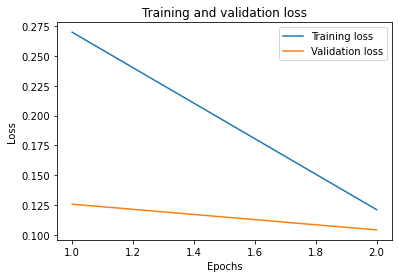

In [59]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

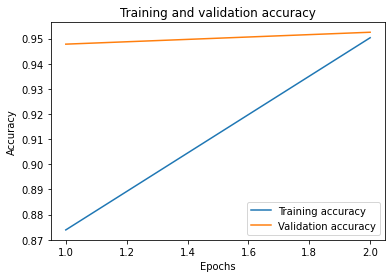

In [60]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show();